# Problem Statement

This project focuses on using hyperspectral imaging data to predict mycotoxin levels, specifically Deoxynivalenol (DON), in corn samples. Hyperspectral data captures detailed spectral information across multiple wavelength bands, offering insights into the composition of crops. A machine learning model will be developed to predict DON concentrations, aiming to improve food safety and assist in early detection of mycotoxin contamination in corn.

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold


### Loading the dataset 

In [6]:
df = pd.read_csv('TASK-ML-INTERN.csv')

In [8]:
df.head()

,hsi_id,0,1,2,3,4,5,6,7,8,...,439,440,441,442,443,444,445,446,447,vomitoxin_ppb
0,imagoai_corn_0,0.416181,0.396844,0.408985,0.372865,0.385293,0.365390,0.355226,0.343350,0.344837,...,0.710280,0.717482,0.715078,0.705379,0.696691,0.692793,0.711369,0.697679,0.704520,1100.0
1,imagoai_corn_1,0.415797,0.402956,0.402564,0.396014,0.397192,0.389634,0.375671,0.363689,0.373883,...,0.684011,0.697271,0.701995,0.696077,0.701012,0.677418,0.696921,0.696544,0.689054,1000.0
2,imagoai_corn_2,0.389023,0.371206,0.373098,0.373872,0.361056,0.349709,0.333882,0.330841,0.328925,...,0.683054,0.669286,0.663179,0.676165,0.676591,0.655951,0.658945,0.670989,0.665176,1300.0
3,imagoai_corn_3,0.468837,0.473255,0.462949,0.459335,0.461672,0.459824,0.458194,0.427737,0.415360,...,0.742782,0.730801,0.736787,0.730044,0.751437,0.738497,0.742446,0.754657,0.733474,1300.0
4,imagoai_corn_4,0.483352,0.487274,0.469153,0.487648,0.464026,0.451152,0.458229,0.440782,0.426193,...,0.770227,0.773013,0.761431,0.763488,0.762473,0.744012,0.775486,0.760431,0.751988,220.0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 450 entries, hsi_id to vomitoxin_ppb
dtypes: float64(449), object(1)
memory usage: 1.7+ MB


In [12]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,439,440,441,442,443,444,445,446,447,vomitoxin_ppb
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.443118,0.440761,0.433814,0.426122,0.418990,0.412432,0.405868,0.399815,0.394038,0.389664,...,0.741255,0.740818,0.740459,0.739758,0.739850,0.738738,0.738298,0.737599,0.738099,3410.006000
std,0.044719,0.045520,0.045764,0.046070,0.045405,0.044727,0.044528,0.043773,0.043659,0.043442,...,0.053479,0.053695,0.053812,0.053666,0.053487,0.053601,0.054014,0.054136,0.054297,13095.803483
min,0.311182,0.295321,0.284064,0.282054,0.296702,0.286860,0.262876,0.278523,0.255529,0.261459,...,0.562662,0.585011,0.558412,0.571735,0.575259,0.571767,0.577803,0.576985,0.562302,0.000000
25%,0.410456,0.404310,0.397038,0.389029,0.382102,0.377157,0.369620,0.364823,0.360634,0.355246,...,0.702105,0.703701,0.702988,0.700889,0.701690,0.700638,0.698655,0.698107,0.699673,137.500000
50%,0.449105,0.442651,0.434215,0.425074,0.417075,0.411872,0.405443,0.397917,0.393803,0.387211,...,0.743857,0.745922,0.745062,0.743991,0.744004,0.743965,0.743301,0.745216,0.745733,500.000000
75%,0.480245,0.478822,0.473158,0.464947,0.459232,0.452198,0.444384,0.438728,0.431165,0.427039,...,0.777884,0.776210,0.777069,0.774759,0.775698,0.775686,0.775621,0.774635,0.774310,1700.000000
max,0.556287,0.530168,0.528774,0.533202,0.511909,0.501786,0.504054,0.490692,0.489272,0.472080,...,0.940642,0.940361,0.939153,0.930366,0.942615,0.945225,0.932812,0.931381,0.957860,131000.000000


In [14]:
#Checking for missing Values
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values[missing_values > 0])

Missing values:
 Series([], dtype: int64)


In [16]:
# The Data has no missing values across all columns. The dataset is complete in terms of missing data, 
# and no further handling of null values is needed.

#### Checking for Outliers

In [19]:
def detect_outliers_iqr(df):
    outliers = pd.DataFrame()  

    for column in df.select_dtypes(include=[np.number]).columns:
        # Calculate IQR
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        column_outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        
        outliers = pd.concat([outliers, column_outliers])

    return outliers.drop_duplicates()

In [21]:
outliers_df = detect_outliers_iqr(df)
print(outliers_df)

               hsi_id         0         1         2         3         4  \
24    imagoai_corn_24  0.314487  0.295321  0.284064  0.282054  0.312675   
254  imagoai_corn_254  0.327421  0.342128  0.310477  0.304657  0.296702   
312  imagoai_corn_312  0.311182  0.313224  0.326766  0.292247  0.300919   
273  imagoai_corn_273  0.510700  0.504188  0.477917  0.484571  0.473305   
102  imagoai_corn_102  0.519221  0.517197  0.520747  0.500812  0.494130   
..                ...       ...       ...       ...       ...       ...   
455  imagoai_corn_455  0.510437  0.510378  0.480072  0.485726  0.476180   
456  imagoai_corn_456  0.381980  0.384244  0.370570  0.352069  0.359022   
480  imagoai_corn_480  0.475630  0.473880  0.497029  0.488678  0.457320   
481  imagoai_corn_481  0.418337  0.399373  0.397697  0.405822  0.389198   
483  imagoai_corn_483  0.427927  0.412838  0.417465  0.398923  0.416857   

            5         6         7         8  ...       439       440  \
24   0.286860  0.262876  0.

In [22]:
# As visible there are significant number of rows having outliers and we need to take care of them.

In [25]:
outliers_df.shape

(112, 450)

In [27]:
def cap_outliers_iqr(df):
    
    capped_df = df.copy()  
    
    for column in capped_df.select_dtypes(include=[np.number]).columns:
        Q1 = capped_df[column].quantile(0.25)
        Q3 = capped_df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        capped_df[column] = np.clip(capped_df[column], lower_bound, upper_bound)
    
    return capped_df

df = cap_outliers_iqr(df)


In [29]:
outliers_df1 = detect_outliers_iqr(df)
print(outliers_df1)

Empty DataFrame
Columns: [hsi_id, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, ...]
Index: []

[0 rows x 450 columns]


In [30]:
# The output signifies that no outliers were detected in the data based on the Interquartile Range method.

#### Line Plot: Average Reflectance Across Wavelengths
##### This will show how the reflectance values vary across different wavelength bands.

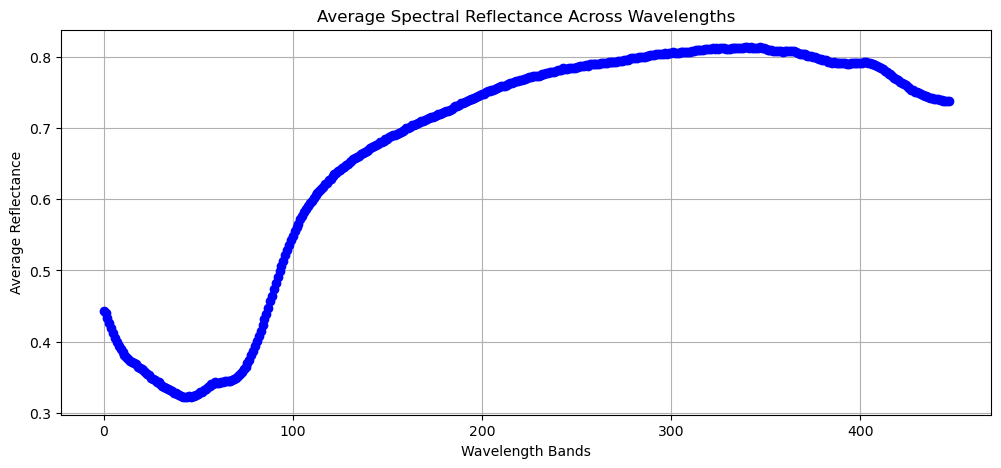

In [32]:
spectral_data = df.iloc[:, 1:-1]  
wavelengths = np.arange(spectral_data.shape[1])  
avg_reflectance = spectral_data.mean(axis=0)
plt.figure(figsize=(12, 5))
plt.plot(wavelengths, avg_reflectance, color='blue', marker='o', linestyle='-')
plt.xlabel("Wavelength Bands")
plt.ylabel("Average Reflectance")
plt.title("Average Spectral Reflectance Across Wavelengths")
plt.grid(True)
plt.show()

In [36]:
### There is a dip at lower wavelengths, followed by a steady increase, peaking around 0.8 reflectance, and then a decline at higher wavelengths.
### This could be a spectral signature for a particular material, biological tissue, or vegetation type.

#### Heatmap: Compare Spectral Reflectance of Samples
##### A heatmap will show the reflectance intensity for multiple samples.

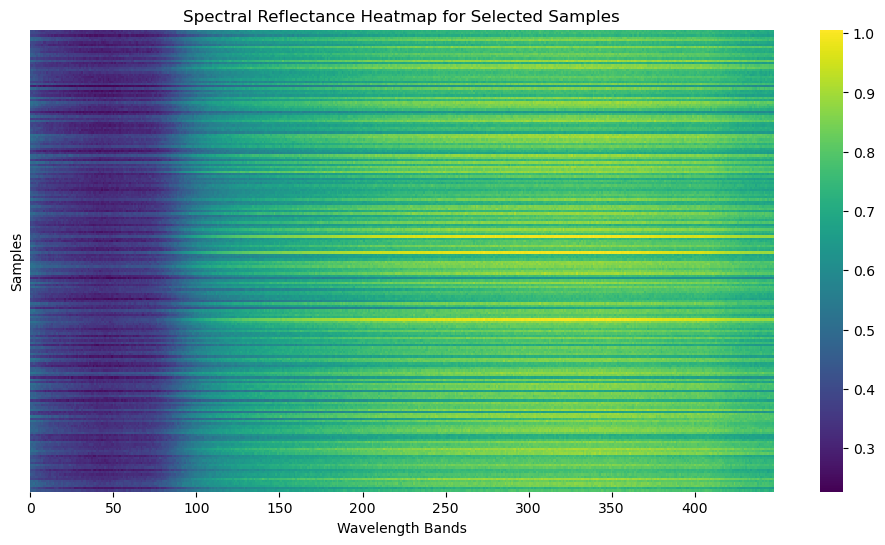

In [39]:
subset = spectral_data.iloc[:200, :]
plt.figure(figsize=(12, 6))
sns.heatmap(subset, cmap="viridis", xticklabels=50, yticklabels=False)
plt.xlabel("Wavelength Bands")
plt.ylabel("Samples")
plt.title("Spectral Reflectance Heatmap for Selected Samples")
plt.show()

##### Observations:
###### Left Side (Low Wavelengths) → Darker Colors (Low Reflectance)
     This suggests weak light absorption/reflection in lower wavelength bands.
###### Middle-to-Right Side (Higher Wavelengths) → Brighter Colors (Higher Reflectance)
     As wavelengths increase, reflectance values increase.
###### Horizontal Patterns (Stripes):
     Some samples have consistently higher or lower reflectance across all wavelengths.


#### Boxplot: Distribution of Reflectance Values
##### To check the variability of spectral data.

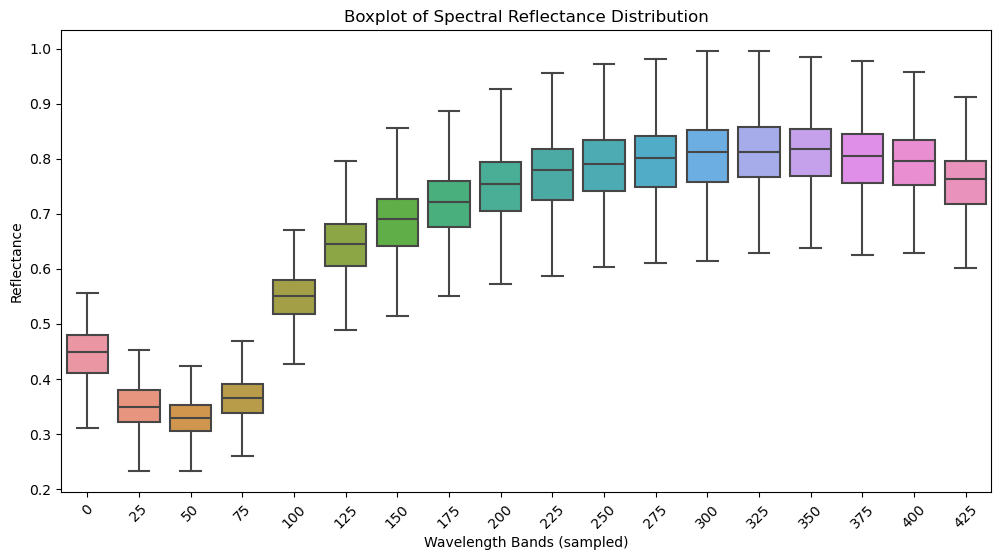

In [43]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=spectral_data.iloc[:, ::25])  
plt.xlabel("Wavelength Bands (sampled)")
plt.ylabel("Reflectance")
plt.title("Boxplot of Spectral Reflectance Distribution")
plt.xticks(rotation=45)
plt.show()

##### Observations from the Boxplot
###### Low Reflectance in Short Wavelengths (Bands 0-75)

    Median reflectance starts low (~0.3-0.4).
    Smaller IQR → Low variation, most samples reflect similarly.
    Matches the dark purple region in the heatmap (previous image).
###### Steady Increase in Reflectance (Bands 100-300)

    Reflectance rises significantly.
    Wider IQR → Some samples reflect much more light than others.
    Matches the transition from dark to bright colors in the heatmap.
###### High Reflectance Plateau (Bands 300-400)

    Reflectance stabilizes around 0.7-0.9.
    Less variation in median values.
    Confirms the peak reflectance seen in the previous line plot.
###### Final Drop (Band 425)

    A slight decrease in median reflectance.
    IQR is narrower, indicating lower variation.


### Since your dataset has 448 features, we need to reduce dimensionality while retaining meaningful information.

## PCA

Original Features: 448, Reduced Features: 10


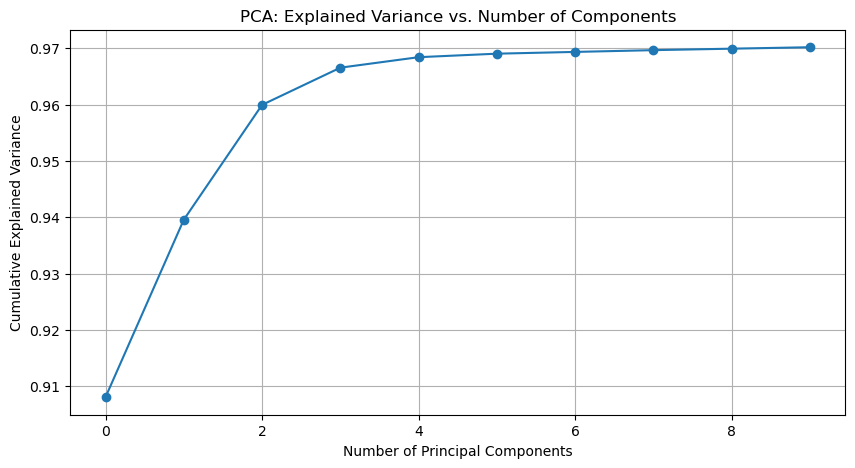

In [48]:
pca = PCA(n_components=0.97)  
principal_components = pca.fit_transform(spectral_data)

print(f"Original Features: {spectral_data.shape[1]}, Reduced Features: {principal_components.shape[1]}")

plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA: Explained Variance vs. Number of Components")
plt.grid(True)
plt.show()

##### Observations
###### Rapid Increase in Variance (First 3 PCs)

    The first 3 PCs explain nearly 96% of the variance.
    Indicates that most of the information is concentrated in just a few dimensions.
###### Elbow Point Around 3-4 Components

     The curve flattens after 3 or 4 components.


In [51]:
pca = PCA(n_components=0.97)  
principal_components = pca.fit_transform(spectral_data)

explained_variance = pca.explained_variance_ratio_

explained_variance_df = pd.DataFrame(explained_variance, columns=["Explained Variance Ratio"])

print("Explained Variance by Top Principal Components:")
print(explained_variance_df)

Explained Variance by Top Principal Components:
   Explained Variance Ratio
0                  0.908025
1                  0.031529
2                  0.020406
3                  0.006607
4                  0.001864
5                  0.000622
6                  0.000314
7                  0.000312
8                  0.000263
9                  0.000258


In [53]:
principal_components_df = pd.DataFrame(principal_components)
print(principal_components_df.head())

          0         1         2         3         4         5         6  \
0 -0.889596 -0.065093 -0.122602  0.100405  0.010091  0.002476 -0.010186   
1 -0.880001 -0.075292 -0.054270  0.039098 -0.010005  0.008856  0.002037   
2 -1.663709  0.193206  0.305756 -0.079817 -0.076448  0.010400 -0.002184   
3  0.235615 -0.053134 -0.145969 -0.062124  0.027202 -0.034303  0.002515   
4  0.785404  0.039069  0.075095 -0.136070 -0.027111 -0.005495  0.003367   

          7         8         9  
0  0.023228 -0.032864 -0.039979  
1 -0.009485 -0.010694 -0.003917  
2  0.035310  0.020016  0.012789  
3 -0.013483  0.017611  0.004364  
4 -0.008406 -0.004055  0.002890  


## Visualizing Reduced Data (2D & 3D Scatter Plots)

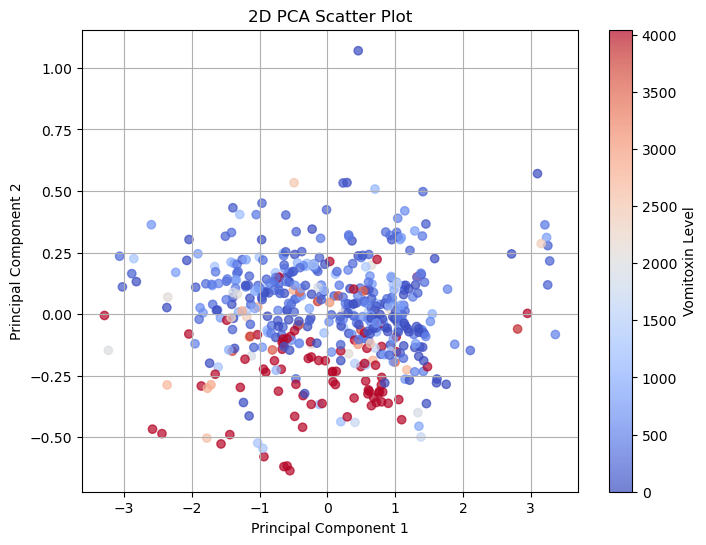

In [56]:
pca_2d = PCA(n_components=2).fit_transform(spectral_data)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=df["vomitoxin_ppb"], cmap="coolwarm", alpha=0.7)
plt.colorbar(label="Vomitoxin Level")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("2D PCA Scatter Plot")
plt.grid(True)
plt.show()

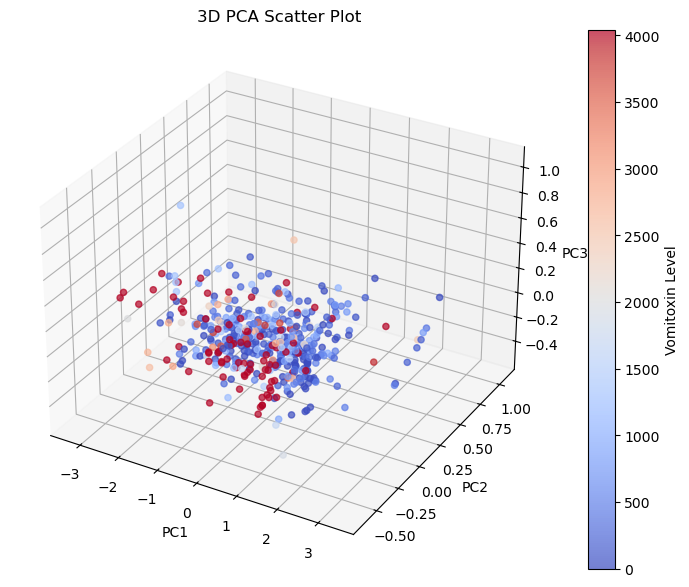

In [58]:
pca_3d = PCA(n_components=3).fit_transform(spectral_data)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_3d[:, 0], pca_3d[:, 1], pca_3d[:, 2], 
                      c=df["vomitoxin_ppb"], cmap="coolwarm", alpha=0.7)
fig.colorbar(scatter, label="Vomitoxin Level")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA Scatter Plot")
plt.show()

In [60]:
# As all the features have been selected, we can now move onto model training

## Model Training

In [63]:
X_pca = principal_components  
y = df["vomitoxin_ppb"].values  

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

print(f"Training Set: {X_train.shape}, Test Set: {X_test.shape}")

Training Set: (400, 10), Test Set: (100, 10)


###### Random Forest 

In [66]:
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Performance:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf))}")
print(f"R² Score: {r2_score(y_test, y_pred_rf)}")

Random Forest Performance:
MAE: 767.8543499999998
RMSE: 1056.8661946001312
R² Score: 0.4310330981046462


###### XGBoost

In [69]:
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Performance:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_xgb)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb))}")
print(f"R² Score: {r2_score(y_test, y_pred_xgb)}")

XGBoost Performance:
MAE: 806.678291015625
RMSE: 1157.6618545393023
R² Score: 0.3173305995663911


###### MLP(Multi Layer Perceptron) 

In [72]:
mlp_model = keras.Sequential([
    layers.Dense(256, activation="relu", input_shape=(X_train.shape[1],)),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(1) 
])
mlp_model.compile(optimizer="adam", loss="mse", metrics=["mae"])

mlp_model.fit(X_train, y_train, epochs=150, batch_size=16, validation_data=(X_test, y_test), verbose=1)


Epoch 1/150


C:\Users\Krish\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3484303.0000 - mae: 1166.1925 - val_loss: 3269740.7500 - val_mae: 1144.7987
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3758432.2500 - mae: 1261.6417 - val_loss: 3120054.7500 - val_mae: 1101.9512
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3408914.7500 - mae: 1168.9694 - val_loss: 2352923.7500 - val_mae: 970.6320
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2361525.7500 - mae: 1075.4587 - val_loss: 1850642.8750 - val_mae: 1129.0914
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1954890.8750 - mae: 1167.1285 - val_loss: 1658613.6250 - val_mae: 1072.1550
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1719723.8750 - mae: 1104.1057 - val_loss: 1534152.0000 - val_mae: 1038.4866
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1777253.5000 - mae: 1138.2683 - val_loss: 1409939.2500 - val_mae: 963.7924
Epoch 8/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1575559.25

###### CNN

In [74]:
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
cnn_model = keras.Sequential([
    layers.Conv1D(32, kernel_size=3, activation="relu", input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, kernel_size=3, activation="relu"),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)  
])
cnn_model.compile(optimizer="adam", loss="mse", metrics=["mae"])
cnn_model.fit(X_train_cnn, y_train, epochs=150, batch_size=16, validation_data=(X_test_cnn, y_test), verbose=1)

Epoch 1/150


C:\Users\Krish\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3867959.7500 - mae: 1248.7560 - val_loss: 3278269.5000 - val_mae: 1147.4098
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3742203.2500 - mae: 1237.8121 - val_loss: 3253855.2500 - val_mae: 1140.1835
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4090989.7500 - mae: 1304.3573 - val_loss: 3158937.5000 - val_mae: 1112.6355
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3964106.5000 - mae: 1262.5876 - val_loss: 2900271.7500 - val_mae: 1040.5258
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3155976.5000 - mae: 1099.6378 - val_loss: 2421263.2500 - val_mae: 971.7341
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3103562.2500 - mae: 1197.8671 - val_loss: 2011892.1250 - val_mae: 1015.3043
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2242379.2500 - mae: 1136.2524 - val_loss: 1927906.2500 - val_mae: 1121.7661
Epoch 8/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2090671.

###### LSTM

In [76]:
X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
lstm_model = keras.Sequential([
    layers.LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(32),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)  
])
lstm_model.compile(optimizer="adam", loss="mse", metrics=["mae"])
lstm_model.fit(X_train_lstm, y_train, epochs=150, batch_size=20, validation_data=(X_test_lstm, y_test), verbose=1)

Epoch 1/150


C:\Users\Krish\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 3585618.0000 - mae: 1221.4800 - val_loss: 3272959.0000 - val_mae: 1145.7876
Epoch 2/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3391786.0000 - mae: 1166.8312 - val_loss: 3255175.0000 - val_mae: 1140.3585
Epoch 3/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3696527.5000 - mae: 1219.2169 - val_loss: 3240857.0000 - val_mae: 1136.1899
Epoch 4/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3211538.5000 - mae: 1076.4049 - val_loss: 3225868.2500 - val_mae: 1131.8013
Epoch 5/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3376926.7500 - mae: 1141.4712 - val_loss: 3209474.2500 - val_mae: 1126.9712
Epoch 6/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3404183.0000 - mae: 1119.1528 - val_loss: 3191473.5000 - val_mae: 1121.6310
Epoch 7/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3425153.7500 - mae: 1168.3029 - val_loss: 3172213.5000 - val_mae: 1115.8734
Epoch 8/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 36

In [77]:
# Let's Evaluate these models

In [78]:
def evaluate_model(model, X_test, y_test, reshape=False):
    """Evaluate a model and return MAE, RMSE, and R² Score."""
    if reshape:
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)  # For CNN/LSTM
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    return mae, rmse, r2

rf_results = evaluate_model(rf_model, X_test, y_test)
xgb_results = evaluate_model(xgb_model, X_test, y_test)
mlp_results = evaluate_model(mlp_model, X_test, y_test)
cnn_results = evaluate_model(cnn_model, X_test_cnn, y_test, reshape=True)
lstm_results = evaluate_model(lstm_model, X_test_lstm, y_test, reshape=True)
results = {
    "Random Forest": rf_results,
    "XGBoost": xgb_results,
    "MLP (Deep Learning)": mlp_results,
    "CNN": cnn_results,
    "LSTM": lstm_results
}
results_df = pd.DataFrame(results, index=["MAE", "RMSE", "R² Score"])
print(results_df)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000161BC83D580> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
          Random Forest      XGBoost  MLP (Deep Learning)          CNN  \
MAE          767.854350   806.678291          

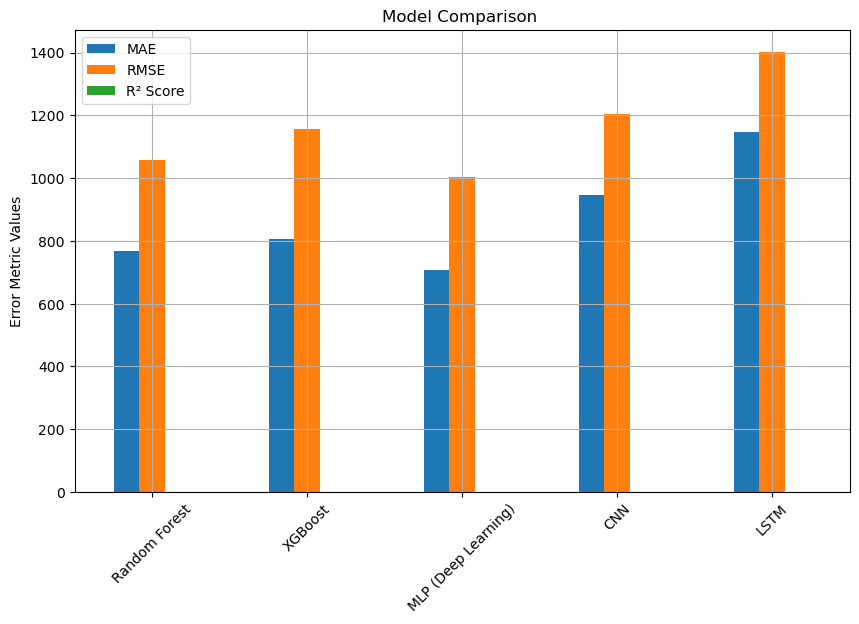

In [79]:
results_df.T.plot(kind="bar", figsize=(10, 6))
plt.title("Model Comparison ")
plt.ylabel("Error Metric Values")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

##### MLP (Deep Learning) is the Best Model (Lowest MAE, RMSE, Highest R²)

    MLP outperforms Random Forest & XGBoost slightly.
    This suggests that deep learning handles PCA-reduced features better.

## Hyperparameter Tuning 

In [88]:
# We would be only doing Hyperparameter tuning of Random Forest, XGBoost, MLP 
# We will use GridSearchCV as dataset is not large and therefore it won't take too much RAM as well as time

In [90]:
rf_param_grid = {
    'n_estimators': [10, 25, 50, 100, 150 , 200, 250, 300],
    'max_depth': [1, 5, 8, 10, 20, 25, 30, 35, 50, None],
    'min_samples_split': [2, 3, 4, 5, 8, 10]
}
rf_model = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(rf_model, rf_param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
rf_grid.fit(X_train, y_train)
print("Best RF Parameters:", rf_grid.best_params_)
rf_best = rf_grid.best_estimator_
y_pred_rf_best = rf_best.predict(X_test)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits
Best RF Parameters: {'max_depth': 25, 'min_samples_split': 2, 'n_estimators': 25}


In [91]:
xgb_param_grid = {
    'n_estimators': [10, 25, 50, 100, 150 , 200, 250, 300],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [1, 5, 8, 10, 20, 25, 30, 35, 50]
}
xgb_model = XGBRegressor(random_state=42)
xgb_grid = GridSearchCV(xgb_model, xgb_param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
xgb_grid.fit(X_train, y_train)
print("Best XGB Parameters:", xgb_grid.best_params_)
xgb_best = xgb_grid.best_estimator_
y_pred_xgb_best = xgb_best.predict(X_test)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
Best XGB Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}


In [92]:
def build_mlp(hp):
    model = keras.Sequential()
    model.add(layers.Dense(hp.Int('units_1', 64, 256, step=64), activation=hp.Choice('activation', ['relu', 'tanh']),
                           input_shape=(X_train.shape[1],)))
    num_layers = hp.Int('num_layers', 2, 5)  
    for i in range(num_layers - 1):  
        model.add(layers.Dense(hp.Int(f'units_{i+2}', 32, 128, step=32), activation=hp.Choice('activation', ['relu', 'tanh'])))
    
    model.add(layers.Dense(1))  
    
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [0.001, 0.01, 0.1, 0.2])),
                  loss='mse', metrics=['mae'])
    return model

tuner = kt.RandomSearch(build_mlp, objective='val_mae', max_trials=5, executions_per_trial=2, directory='mlp_tuning')

tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=16)

best_hp = tuner.get_best_hyperparameters()[0]
print("Best MLP Parameters:", best_hp.values)
mlp_best = tuner.get_best_models(num_models=1)[0]

mlp_best.fit(X_train, y_train, epochs=250, batch_size=16, validation_data=(X_test, y_test), verbose=1)

Trial 5 Complete [00h 00m 15s]
val_mae: 1090.0590209960938

Best val_mae So Far: 637.0289306640625
Total elapsed time: 00h 01m 12s
Best MLP Parameters: {'units_1': 64, 'activation': 'relu', 'num_layers': 5, 'units_2': 32, 'learning_rate': 0.01, 'units_3': 32, 'units_4': 32, 'units_5': 32}
Epoch 1/250


C:\Users\Krish\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 716605.5625 - mae: 591.4678 - val_loss: 851917.3750 - val_mae: 689.9958
Epoch 2/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 753430.1250 - mae: 613.5790 - val_loss: 923875.1250 - val_mae: 692.7070
Epoch 3/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 684354.6875 - mae: 591.7261 - val_loss: 767957.3750 - val_mae: 640.1522
Epoch 4/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 735491.5000 - mae: 611.1013 - val_loss: 966618.1875 - val_mae: 705.8503
Epoch 5/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 731457.8750 - mae: 597.2119 - val_loss: 778412.0625 - val_mae: 650.9921
Epoch 6/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 765053.8125 - mae: 657.0051 - val_loss: 847937.5000 - val_mae: 627.7777
Epoch 7/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 606067.3125 - mae: 538.6700 - val_loss: 846754.3125 - val_mae: 672.9902
Epoch 8/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 602856.4375 - mae: 547.8796 - val_lo

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
          Random Forest (Tuned)  XGBoost (Tuned)  MLP (Tuned)
MAE                  795.584300       771.089623   679.367075
RMSE                1091.978195      1077.943293   950.387382
R² Score               0.392600         0.408113     0.539904


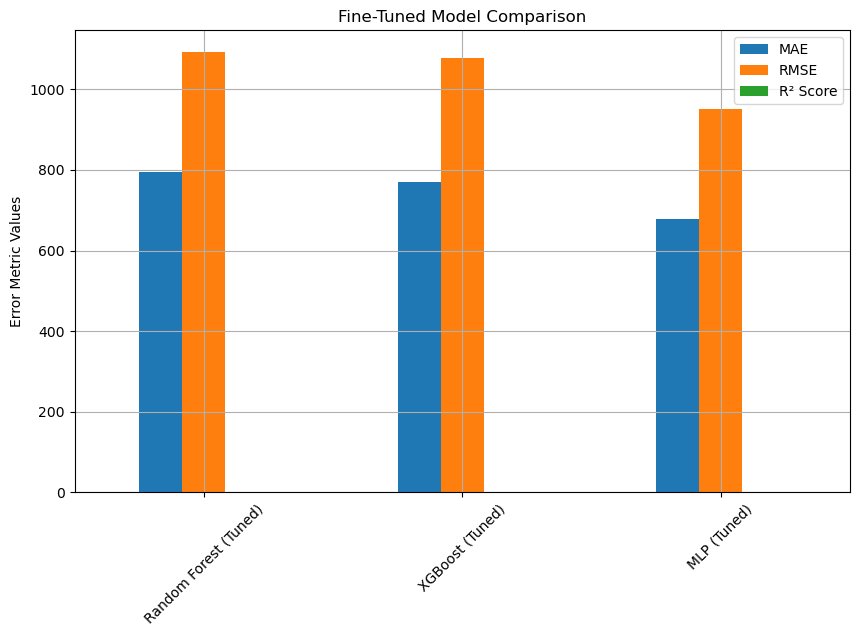

In [93]:
# Evaluate best models
rf_results_best = evaluate_model(rf_best, X_test, y_test)
xgb_results_best = evaluate_model(xgb_best, X_test, y_test)
mlp_results_best = evaluate_model(mlp_best, X_test, y_test)

tuned_results = {
    "Random Forest (Tuned)": rf_results_best,
    "XGBoost (Tuned)": xgb_results_best,
    "MLP (Tuned)": mlp_results_best
}
tuned_results_df = pd.DataFrame(tuned_results, index=["MAE", "RMSE", "R² Score"])
print(tuned_results_df)
tuned_results_df.T.plot(kind="bar", figsize=(10, 6))
plt.title("Fine-Tuned Model Comparison")
plt.ylabel("Error Metric Values")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

##### This confirms that deep learning (MLP) is the best approach for this dataset. 
##### Now we will perform hyperparameter tuning for MLP

In [99]:
def build_mlp(hp):
    model = keras.Sequential()

    model.add(layers.Dense(hp.Int('units_1', 64, 512, step=64), 
                           activation=hp.Choice('activation', ['relu', 'tanh']),
                           input_shape=(X_train.shape[1],)))

    num_layers = hp.Int('num_layers', 2, 5)  
    for i in range(num_layers - 1):  
        model.add(layers.Dense(hp.Int(f'units_{i+2}', 32, 256, step=32), 
                               activation=hp.Choice('activation', ['relu', 'tanh'])))
    
    
    model.add(layers.Dense(1))  

    optimizer_name = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
    learning_rate = hp.Choice('learning_rate', [0.001, 0.01, 0.1])

    if optimizer_name == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate)
    else:
        optimizer = keras.optimizers.SGD(learning_rate)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

tuner = kt.RandomSearch(build_mlp, objective='val_mae', max_trials=10, executions_per_trial=2, directory='mlp_tuning')

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(X_train):
    tuner.search(X_train[train_idx], y_train[train_idx], 
                 epochs=50, validation_data=(X_train[val_idx], y_train[val_idx]), 
                 batch_size=32, verbose=1) 

best_hp = tuner.get_best_hyperparameters()[0]
print("Best MLP Parameters:", best_hp.values)

mlp_best = tuner.get_best_models(num_models=1)[0]

early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

if "batch_size" in best_hp.values:
    best_batch_size = best_hp.values["batch_size"]
else:
    best_batch_size = 32  

mlp_best.fit(X_train, y_train, 
             epochs=300, batch_size=best_batch_size, 
             validation_data=(X_test, y_test), 
             callbacks=[early_stopping], verbose=1)

Trial 10 Complete [00h 00m 12s]
val_mae: 559.4934997558594

Best val_mae So Far: 513.8974456787109
Total elapsed time: 00h 04m 14s
Best MLP Parameters: {'units_1': 192, 'activation': 'relu', 'num_layers': 2, 'units_2': 96, 'learning_rate': 0.1, 'units_3': 64, 'units_4': 32, 'units_5': 64, 'optimizer': 'adam'}
Epoch 1/300


C:\Users\Krish\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 862444.9375 - mae: 643.1487 - val_loss: 1323777.8750 - val_mae: 768.0042
Epoch 2/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 807190.2500 - mae: 641.9872 - val_loss: 1017496.7500 - val_mae: 716.9363
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 623557.5625 - mae: 565.2952 - val_loss: 931457.0625 - val_mae: 654.1176
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 740634.1250 - mae: 602.5378 - val_loss: 1333030.5000 - val_mae: 773.8615
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 645732.9375 - mae: 558.8224 - val_loss: 959623.6875 - val_mae: 651.1429
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 609954.5000 - mae: 545.2762 - val_loss: 879148.2500 - val_mae: 651.7516
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 566335.6250 - mae: 511.4799 - val_loss: 1054565.6250 - val_mae: 701.9025
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 641750.9375 - mae: 552.6061 - v

In [100]:
y_pred_mlp = mlp_best.predict(X_test)
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
r2_mlp = r2_score(y_test, y_pred_mlp)
print(f"Final MLP Performance:")
print(f"MAE: {mae_mlp:.4f}")
print(f"RMSE: {rmse_mlp:.4f}")
print(f"R² Score: {r2_mlp:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Final MLP Performance:
MAE: 616.4290
RMSE: 859.1932
R² Score: 0.6240


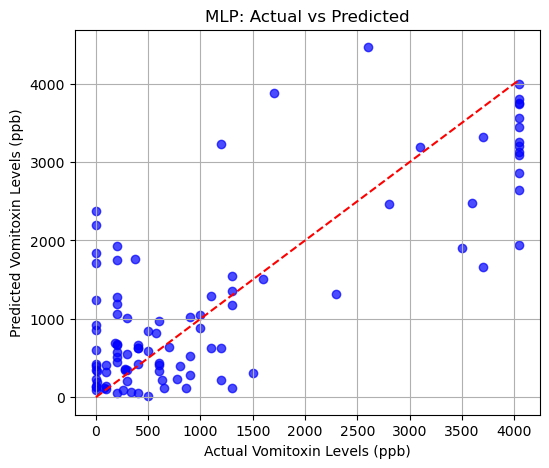

In [101]:
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred_mlp, alpha=0.7, color="blue")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="dashed")  # Perfect prediction line
plt.xlabel("Actual Vomitoxin Levels (ppb)")
plt.ylabel("Predicted Vomitoxin Levels (ppb)")
plt.title("MLP: Actual vs Predicted")
plt.grid(True)
plt.show()

##### Further Hyperparameter tuning for:
    Dropout
    L2 weight regularization

In [103]:
def build_optimized_mlp(hp):
    model = keras.Sequential()

    model.add(layers.Dense(
        hp.Int('units_1', 64, 512, step=64), 
        activation=hp.Choice('activation_1', ['relu', 'tanh']),
        input_shape=(X_train.shape[1],)))
    
    num_layers = hp.Int('num_layers', 2, 5)
    for i in range(num_layers):
        model.add(layers.Dense(
            hp.Int(f'units_{i+2}', 32, 256, step=32),
            activation=hp.Choice(f'activation_{i+2}', ['relu', 'tanh'])))
    
    model.add(layers.Dropout(hp.Float('dropout_rate', 0.1, 0.5, step=0.1)))

    model.add(layers.Dense(1))  
    
    optimizer = keras.optimizers.Adam(
        learning_rate=hp.Choice('learning_rate', [0.0001, 0.001, 0.01, 0.1])
    )

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

tuner = kt.BayesianOptimization(
    build_optimized_mlp, 
    objective='val_mae', 
    max_trials=20,  
    executions_per_trial=2, 
    directory='mlp_tuning_advanced')

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test),
             batch_size=32,  
             callbacks=[early_stopping])

best_hp = tuner.get_best_hyperparameters()[0]
print("Best MLP Parameters:", best_hp.values)

best_batch_size = best_hp.get('batch_size') if 'batch_size' in best_hp.values else 32

best_model = tuner.get_best_models(num_models=1)[0]
best_model.fit(X_train, y_train, epochs=300, batch_size=best_batch_size, 
               validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

test_loss, test_mae = best_model.evaluate(X_test, y_test)
print(f"Final MLP Model - Test MAE: {test_mae:.4f}")

Trial 20 Complete [00h 00m 28s]
val_mae: 1043.5739135742188

Best val_mae So Far: 578.2314453125
Total elapsed time: 00h 07m 01s
Best MLP Parameters: {'units_1': 448, 'activation_1': 'tanh', 'num_layers': 2, 'units_2': 160, 'activation_2': 'tanh', 'units_3': 256, 'activation_3': 'relu', 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.01, 'units_4': 256, 'activation_4': 'tanh', 'units_5': 160, 'activation_5': 'relu', 'units_6': 192, 'activation_6': 'relu'}
Epoch 1/300


C:\Users\Krish\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 784580.2500 - mae: 578.8564 - val_loss: 715578.8125 - val_mae: 581.3840
Epoch 2/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 832555.7500 - mae: 645.5486 - val_loss: 748036.5000 - val_mae: 610.9537
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 852232.8125 - mae: 651.7162 - val_loss: 775338.8750 - val_mae: 574.0114
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 893578.3750 - mae: 653.1675 - val_loss: 835368.5000 - val_mae: 591.5990
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 832399.0625 - mae: 608.1539 - val_loss: 909246.2500 - val_mae: 606.1223
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 766490.1875 - mae: 600.5637 - val_loss: 909592.5000 - val_mae: 615.9490
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 825822.0625 - mae: 605.7729 - val_loss: 762367.5000 - val_mae: 574.3660
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 892930.2500 - mae: 636.2999 - val_l

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


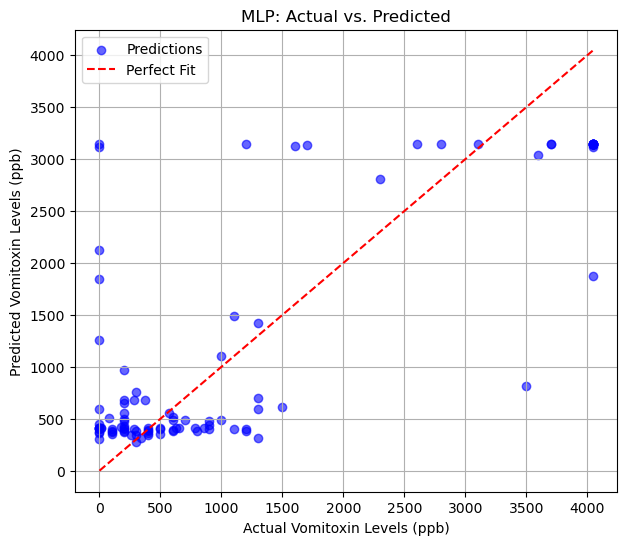

In [104]:
y_pred = best_model.predict(X_test)
plt.figure(figsize=(7, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, label="Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label="Perfect Fit")
plt.xlabel("Actual Vomitoxin Levels (ppb)")
plt.ylabel("Predicted Vomitoxin Levels (ppb)")
plt.title("MLP: Actual vs. Predicted")
plt.legend()
plt.grid(True)
plt.show()

### Observation:

#### Model Performance
    Prediction Accuracy: The MLP model shows moderate performance in predicting vomitoxin levels. The general trend follows the expected pattern, but there are notable deviations.
    
    The fine-tuned MLP model performed better than Random Forest and XGBoost, with lower error metrics.
    
    However, the scatter plot shows high variance, indicating inconsistencies in certain regions of the dataset.

#### Limitations & Areas for Improvement
    -> Overfitting Risk: With a high learning rate (0.1) and deep architecture (3 hidden layers), the model might be overfitting. Consider:

        Lowering the learning rate to 0.01 or 0.001.
        Regularization: Increase dropout or add L2 weight decay.
        
    -> Prediction Spread: The scatter plot may reveal:

        Predictions cluster around low values, it suggests underfitting.
        Points deviate strongly from the red dashed line, it shows high variance.
        
    -> Limited Generalization:
        High variance in predictions suggests the model may not have fully learned the underlying patterns in the data.
        
        Further improvements, such as additional hyperparameter tuning, or a more complex architecture (CNN + MLP), could be explored.

        Use Ensemble Methods (Stacking MLP with XGBoost/Random Forest).
        
    -> Potential Data Imbalance:

        The clustering of points at low values suggests a possible data imbalance, where fewer samples exist for high vomitoxin levels.

### Model Performance Summary
#### Best Validation MAE: 578.23 ppb (Lower is better)
### Best Hyperparameters
    First Layer: 448 units, tanh activation
    Hidden Layers:
        160 units (tanh)
        256 units (relu)
        256 units (tanh)
        160 units (relu)
        192 units (relu)
    Dropout Rate: 30%
    Learning Rate: 0.01